In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-tanvir/Coffee Bean.csv
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (2).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (95).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (45).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (8).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (83).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (15).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (98).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (91).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (22).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (23).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (75).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (55).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (11).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (39).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (100).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (33).png
/kaggle/input/coffee-bean-tanvir/test/Da

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

2025-08-27 17:59:20.660379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756317560.912602      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756317560.982756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = "/kaggle/input/coffee-bean-tanvir"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [4]:
def gcnet_block(x, reduction=16):
    """Global Context Network Attention Block"""
    input_shape = x.shape
    channels = input_shape[-1]

    # Global context
    context = layers.GlobalAveragePooling2D()(x)
    context = layers.Reshape((1,1,channels))(context)

    # Transform
    transform = layers.Conv2D(channels // reduction, (1,1), activation='relu', padding='same')(context)
    transform = layers.Conv2D(channels, (1,1), activation='sigmoid', padding='same')(transform)

    # Scale
    out = layers.Multiply()([x, transform])
    return out

In [5]:
def build_gcnet_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = gcnet_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = gcnet_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = gcnet_block(x)

    # Flatten + Dense
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_gcnet_cnn(num_classes=num_classes)
model.summary()

I0000 00:00:1756317574.241822      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 1, 2)   │         66 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 32)  │         96 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 4)   │        260 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 64)  │        320 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│ (Multiply)          │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ multiply_1[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 8,486,066 (32.37 MB)

 Trainable params: 8,486,066 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756317581.581634      73 service.cc:148] XLA service 0x7c6a54009fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756317581.582449      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756317582.177173      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 6:19 10s/step - accuracy: 0.3438 - loss: 1.3850

I0000 00:00:1756317586.840300      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 536ms/step - accuracy: 0.2862 - loss: 1.3779 - val_accuracy: 0.6400 - val_loss: 0.8514
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.5680 - loss: 0.8827 - val_accuracy: 0.6000 - val_loss: 0.9089
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.7819 - loss: 0.5064 - val_accuracy: 0.5625 - val_loss: 1.0685
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.8517 - loss: 0.3966 - val_accuracy: 0.8875 - val_loss: 0.2721
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9109 - loss: 0.2207 - val_accuracy: 0.8800 - val_loss: 0.2822
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9389 - loss: 0.1643 - val_accuracy: 0.9150 - val_loss: 0.2460
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.9458 - loss: 0.1605 - val_accuracy: 0.9650 - val_loss: 0.1086
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9530 - loss: 0.1379 - val_accuracy: 0.9225 - val

In [7]:
def extract_features(model, generator):
    feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-3].output)
    features = []
    labels = []

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = feature_extractor.predict(x_batch)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train_feat, y_train_labels = extract_features(model, train_generator)
X_test_feat, y_test_labels = extract_features(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

In [9]:
# Initialize and train a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # You can adjust n_estimators
rf_model.fit(X_train_scaled, y_train_labels)

# Evaluate on the test set
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute AUC only if >1 class present
classes_present = np.unique(y_test_labels)
if len(classes_present) > 1:
    y_test_bin = label_binarize(y_test_labels, classes=np.unique(y_train_labels)) # Use all possible classes for binarization
    auc_score = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr')
    print(f"Test ROC-AUC: {auc_score:.4f}")
else:
    print("Test ROC-AUC skipped (only 1 class in test set)")

Test Accuracy: 0.9650
Test ROC-AUC: 0.9989


Accuracy: 0.965
Precision: 0.9666467076260891
Recall: 0.965
F1-score: 0.9653102264944562
Confusion Matrix:
 [[95  0  0  5]
 [ 0 96  2  2]
 [ 0  0 97  3]
 [ 2  0  0 98]]


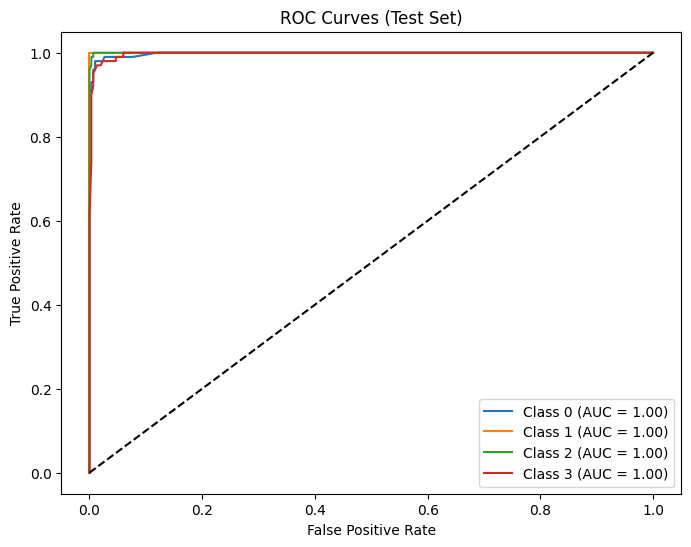

Test AUC: 0.9989041666666666


In [10]:
# Evaluate on the test set using the trained RandomForestClassifier
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)

# Calculate metrics
print("Accuracy:", accuracy_score(y_test_labels, y_test_pred))
print("Precision:", precision_score(y_test_labels, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test_labels, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test_labels, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_test_pred))

# ROC-AUC
classes_present = np.unique(y_test_labels)
if len(classes_present) > 1:
    y_test_bin = label_binarize(y_test_labels, classes=np.unique(y_train_labels)) # Use all possible classes for binarization
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {np.unique(y_train_labels)[i]} (AUC = {auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")